In [1]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

<h1> Pivioting

In [4]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [5]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [6]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [7]:
df_fish = spark.read.format("org.apache.spark.sql.cassandra").options(table="fish_table_year", keyspace="fish_keyspace").load()
df_fish.show()

+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+-------------------+----+----+
|localityweekid|avgadultfemalelice|      date|hascleanerfishdeployed|hasila|hasmechanicalremoval|haspd|hasreportedlice|hassalmonoids|hassubstancetreatments|infilteredselection|isfallow|isonland|isslaughterholdingcage|      lat|localityno|      lon|municipality|municipalityno|               name|week|year|
+--------------+------------------+----------+----------------------+------+--------------------+-----+---------------+-------------+----------------------+-------------------+--------+--------+----------------------+---------+----------+---------+------------+--------------+-------------------+----+----+
|       1293141|               0.1|2021-09-06|                 false| false|   

In [8]:
# Make spark dataframe to pandas dataframe
df_fish = df_fish.toPandas()

In [9]:
# Create a variable called region, splitting Norway into three regions: South - below 63.81 latitude, Middle - up to 68.85 latitude, North - above 68.85 latitude.
df_fish['region'] = 'NaN'
df_fish.loc[df_fish['lat'] < 63.81, 'region'] = 'South'
df_fish.loc[(df_fish['lat'] >= 63.81) & (df_fish['lat'] <= 68.85), 'region'] = 'Middle'
df_fish.loc[df_fish['lat'] > 68.85, 'region'] = 'North'

In [10]:
# combine year and week into new column called year_week
df_fish['year_week'] = df_fish['year'].astype(str) + '-' + df_fish['week'].astype(str)

In [11]:
# Create the following "Gropuby"s: category: week and values: avgadultfemalelice
df_fish_grouped = df_fish.groupby('year_week')['avgadultfemalelice'].mean().reset_index(name='avg_adult_female_lice')


In [12]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice
0,2021-1,0.161059
1,2021-10,0.152289
2,2021-11,0.150929
3,2021-12,0.141850
4,2021-13,0.130290


In [13]:
import pandas as pd
# get the first date in each week and add it to the dataframe
df_fish_grouped['date'] = pd.to_datetime(df_fish_grouped['year_week'] + '-1', format="%Y-%W-%w")

# have to groupby year_week since the data spans over two years

In [14]:
df_fish_grouped.head()

,year_week,avg_adult_female_lice,date
0,2021-1,0.161059,2021-01-04
1,2021-10,0.152289,2021-03-08
2,2021-11,0.150929,2021-03-15
3,2021-12,0.141850,2021-03-22
4,2021-13,0.130290,2021-03-29


<Axes: xlabel='date'>

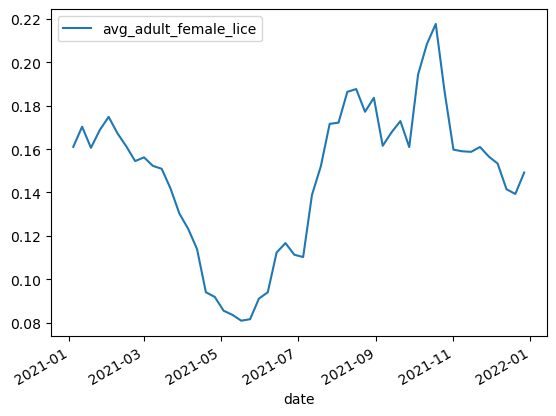

In [15]:
# plot the df_fish_grouped dataframe
import matplotlib.pyplot as plt

df_fish_grouped.plot(x='date', y='avg_adult_female_lice')


In [16]:
# Create the following piviot tables:
# category: haspd and haslla, values: lat

df_fish_pivot = df_fish.pivot_table(index='year_week', values=['haspd', 'hasila'], aggfunc='mean').reset_index()

In [17]:
df_fish_pivot.head()

,year_week,hasila,haspd
0,2021-1,0.009434,0.078420
1,2021-10,0.008211,0.075660
2,2021-11,0.008211,0.076246
3,2021-12,0.008798,0.074487
4,2021-13,0.008798,0.072727


In [18]:
# get the first date in each week and add it to the dataframe
df_fish_pivot['date'] = pd.to_datetime(df_fish_pivot['year_week'] + '-1', format="%Y-%W-%w")

In [19]:
df_fish_pivot.head()

,year_week,hasila,haspd,date
0,2021-1,0.009434,0.078420,2021-01-04
1,2021-10,0.008211,0.075660,2021-03-08
2,2021-11,0.008211,0.076246,2021-03-15
3,2021-12,0.008798,0.074487,2021-03-22
4,2021-13,0.008798,0.072727,2021-03-29


<Axes: xlabel='date'>

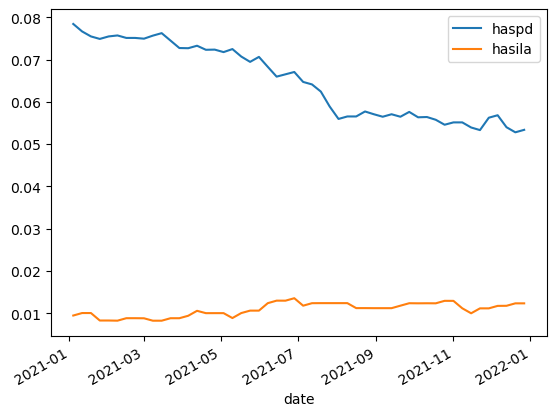

In [20]:
# plot the df_fish_pivot dataframe
df_fish_pivot.plot(x='date', y=['haspd', 'hasila'])

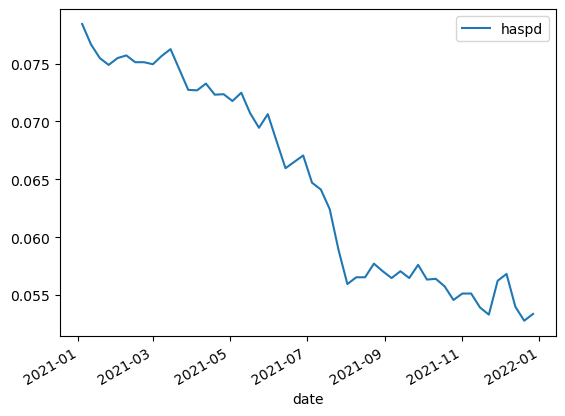

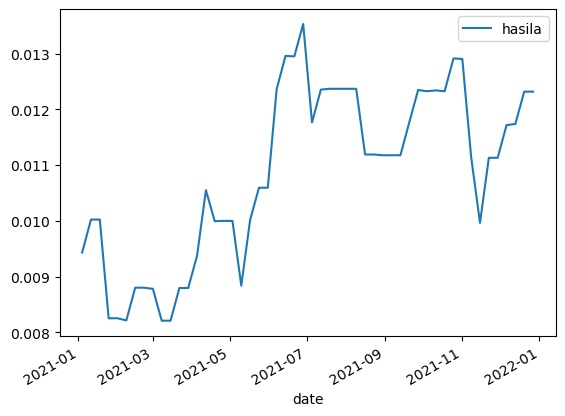

In [21]:
# Plot indepentently
df_fish_pivot.plot(x='date', y='haspd')
df_fish_pivot.plot(x='date', y='hasila')

plt.show()

In [22]:
# Create the following piviot tables:

# Category: region and year_week, values: avgadultfemalelice

df_fish_pivot2 = df_fish.pivot_table(index=['region', 'year_week'], values='avgadultfemalelice', aggfunc='mean').reset_index()

# Get the first date in each week and add it to the dataframe
df_fish_pivot2['date'] = pd.to_datetime(df_fish_pivot2['year_week'] + '-1', format="%Y-%W-%w")

<Axes: xlabel='date', ylabel='avgadultfemalelice'>

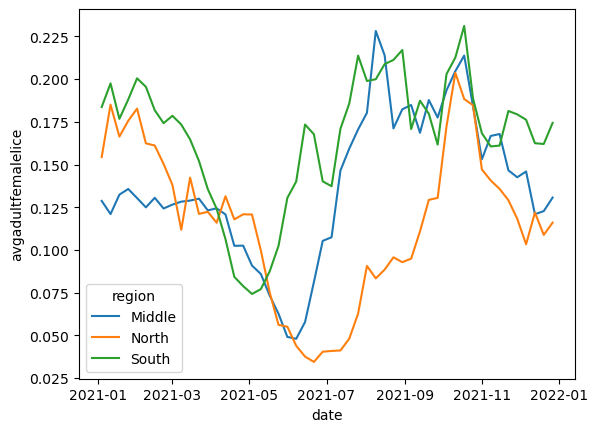

In [23]:
# Plot the df_fish_pivot2 dataframe with region as hue
import seaborn as sns
sns.lineplot(data=df_fish_pivot2, x='date', y='avgadultfemalelice', hue='region')

# you can see that the middle and north regions follows the south region with a delay of 1-2 months.

<h1> Forecasting

In [24]:
# Read from Cassandra - lice_count_table
df_lice = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()

# make spark dataframe to pandas dataframe
df_lice = df_lice.toPandas()
df_lice.head()

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,seatemperature,specieslist,week,year
0,2021-02-15,0.06,0.54,0.09,Andholmen 1,4.8,"['Laks', 'Ørret', 'Regnbueørret']",7,2021
1,2021-10-25,0.44,0.65,0.06,Andholmen 1,11.0,"['Laks', 'Ørret', 'Regnbueørret']",43,2021
2,2021-02-01,0.02,0.91,0.06,Andholmen 1,5.1,"['Laks', 'Ørret', 'Regnbueørret']",5,2021
3,2021-10-11,0.38,0.68,0.06,Andholmen 1,11.7,"['Laks', 'Ørret', 'Regnbueørret']",41,2021
4,2021-08-16,0.48,1.42,0.06,Andholmen 1,14.3,"['Laks', 'Ørret', 'Regnbueørret']",33,2021


In [25]:
# Drop the following columns: localityname, specieslist, week and year in df_lice
df_lice = df_lice.drop(['localityname', 'specieslist', 'week', 'year'], axis=1)
df_lice.head()

,year_week,avgadultfemalelice,avgmobilelice,avgstationarylice,seatemperature
0,2021-02-15,0.06,0.54,0.09,4.8
1,2021-10-25,0.44,0.65,0.06,11.0
2,2021-02-01,0.02,0.91,0.06,5.1
3,2021-10-11,0.38,0.68,0.06,11.7
4,2021-08-16,0.48,1.42,0.06,14.3


In [26]:
# Define the lagged correlation function
def lagged_correlation(lag=0, seatemperature='seatemperature', licetype='avgadultfemalelice'):
    y = df_lice[seatemperature]
    x = df_lice[licetype]

    # Apply the lag
    x_lagged = x.shift(lag)  # Shift the lice data by 'lag'
    valid_index = ~np.isnan(x_lagged) & ~np.isnan(y)  # Remove NaN values for correlation calculation
    corr = np.corrcoef(y[valid_index], x_lagged[valid_index])[0, 1]
    
    # Print the result
    print(f"Correlation between {seatemperature} and {licetype} lagged {lag} timepoints: {corr:.3f}")

# Define the function to calculate and plot the sliding window correlation
def plot_swc(center, window, seatemperature='seatemperature', licetype='avgadultfemalelice'):
    y = df_lice[seatemperature]
    x = df_lice[licetype]

    # Calculate the sliding window correlation
    swc = y.rolling(window, center=True).corr(x)

    # Define the window bounds
    window_start = max(center - window // 2, 0)
    window_end = min(center + window // 2, len(df_lice))
        
    # Plot the data
    plt.figure(figsize=(14, 7))

    # Plot sea temperature
    plt.subplot(3, 1, 1)
    plt.plot(y.index, y, label=seatemperature)
    plt.plot(y.index[window_start:window_end], y[window_start:window_end], 'r', label='Window Frame')
    plt.ylabel(seatemperature)
    plt.xlim(y.index.min(), y.index.max())

    # Plot lice type
    plt.subplot(3, 1, 2)
    plt.plot(x.index, x, label=licetype)
    plt.plot(x.index[window_start:window_end], x[window_start:window_end], 'r', label='Window Frame')
    plt.ylabel(licetype)
    plt.xlim(x.index.min(), x.index.max())

    # Plot the sliding window correlation
    plt.subplot(3, 1, 3)
    plt.plot(swc.index, swc, label='SWC')
    plt.axvline(x=swc.index[center], color='red', linestyle='--', label='Center')
    plt.ylabel('SWC')
    plt.axhline(y=0, color='gray', linestyle='--')
    plt.ylim(-1, 1)
    plt.xlim(swc.index.min(), swc.index.max())
    plt.legend()
    plt.tight_layout()
    plt.show()

In [27]:
# Use interact to create the sliders and input options
interact(plot_swc,
         center=(1, len(df_lice)-1, 1),  # Center slider
         window=(1, len(df_lice)-1, 1),  # Window size slider
         seatemperature=['seatemperature'],  # Dropdown for sea temperature
         licetype=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'])  # Dropdown for lice types

# Also update the interact function for lagged_correlation
interact(lagged_correlation, lag=(0, len(df_lice)-1, 1),
         seatemperature=['seatemperature'],
         licetype=['avgadultfemalelice', 'avgmobilelice', 'avgstationarylice'])

interactive(children=(IntSlider(value=26, description='center', max=51, min=1), IntSlider(value=26, descriptio…

interactive(children=(IntSlider(value=0, description='lag', max=51), Dropdown(description='seatemperature', op…

<function __main__.lagged_correlation(lag=0, seatemperature='seatemperature', licetype='avgadultfemalelice')>

<h3> Forecating part 2


In [28]:
# get combine_df from Cassandra
df_sync = spark.read.format("org.apache.spark.sql.cassandra").options(table="combine_table", keyspace="fish_keyspace").load()

# make spark dataframe to pandas dataframe
df_sync = df_sync.toPandas()
df_sync.head()


,referencetime,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname,mean_air_temperature,mean_relative_humidity,mean_wind_speed,seatemperature,sum_precipitation_amount
0,2021-05-23,0.07,0.16,0.02,Andholmen 1,8.485714,87.142857,5.257143,8.3,14.1
1,2021-10-17,0.38,0.68,0.06,Andholmen 1,8.378571,80.285714,9.800000,11.7,133.0
2,2021-10-31,0.44,0.65,0.06,Andholmen 1,10.671429,88.571429,7.442857,11.0,39.8
3,2021-06-27,0.11,0.22,0.01,Andholmen 1,11.442857,87.285714,6.128571,11.8,8.2
4,2021-09-26,0.86,1.91,0.05,Andholmen 1,11.607143,89.571429,8.600000,12.3,56.7


In [29]:
# drop the following columns: localityname
df_sync = df_sync.drop(['localityname'], axis=1)

In [30]:
df_sync['referencetime'] = pd.to_datetime(df_sync['referencetime'])

df_sync.index = df_sync['referencetime']

df_sync = df_sync.asfreq('W')

# drop the following columns: referencetime
df_sync = df_sync.drop(['referencetime'], axis=1)

#Sort the values in df_sync by referencetime
df_sync = df_sync.sort_values(by='referencetime')

In [31]:
# Make a bfill lag of one time step for each column except for referencetime

df_sync['avgadultfemalelice_lag'] = df_sync['avgadultfemalelice'].shift(1).bfill()
df_sync['avgmobilelice_lag'] = df_sync['avgmobilelice'].shift(1).bfill()
df_sync['avgstationarylice_lag'] = df_sync['avgstationarylice'].shift(1).bfill()
df_sync['seatemperature_lag'] = df_sync['seatemperature'].shift(1).bfill()
df_sync['mean_air_temperature_lag'] = df_sync['mean_air_temperature'].shift(1).bfill()
df_sync['mean_wind_speed_lag'] = df_sync['mean_wind_speed'].shift(1).bfill()
df_sync['mean_relative_humidity_lag'] = df_sync['mean_relative_humidity'].shift(1).bfill()
df_sync['sum_precipitation_amount_lag'] = df_sync['sum_precipitation_amount'].shift(1).bfill()


df_sync.head()

,avgadultfemalelice,avgmobilelice,avgstationarylice,mean_air_temperature,mean_relative_humidity,mean_wind_speed,seatemperature,sum_precipitation_amount,avgadultfemalelice_lag,avgmobilelice_lag,avgstationarylice_lag,seatemperature_lag,mean_air_temperature_lag,mean_wind_speed_lag,mean_relative_humidity_lag,sum_precipitation_amount_lag
referencetime,,,,,,,,,,,,,,,,
2021-01-10,0.06,0.11,0.00,1.835714,76.428571,5.985714,6.9,8.4,0.06,0.11,0.00,6.9,1.835714,5.985714,76.428571,8.4
2021-01-17,0.00,0.10,0.08,-0.342857,78.000000,4.728571,6.0,16.6,0.06,0.11,0.00,6.9,1.835714,5.985714,76.428571,8.4
2021-01-24,0.01,0.22,0.22,3.657143,73.714286,5.714286,5.9,25.0,0.00,0.10,0.08,6.0,-0.342857,4.728571,78.000000,16.6
2021-01-31,0.02,0.62,0.12,2.471429,79.285714,8.928571,5.5,50.6,0.01,0.22,0.22,5.9,3.657143,5.714286,73.714286,25.0
2021-02-07,0.02,0.91,0.06,-1.821429,65.857143,5.014286,5.1,3.5,0.02,0.62,0.12,5.5,2.471429,8.928571,79.285714,50.6


In [32]:
import statsmodels.api as sm

# SARIMAX model 
mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'], df_sync[["avgadultfemalelice", "avgmobilelice", "avgstationarylice", "mean_air_temperature", "mean_relative_humidity", "mean_wind_speed", "sum_precipitation_amount"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -33.674
Date:                Mon, 20 Nov 2023   AIC                             89.349
Time:                        13:01:19   BIC                            110.381
Sample:                    01-10-2021   HQIC                            97.358
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
intercept                   -0.0039      0.032     -0.121      0.904      -0.067       0.059
avgadultfemalelice          -0.1977      0.641     -0.308      0.758      -1.454       1.

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [33]:
# SARIMAX model again with lagged variables

mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'],\
    df_sync[["avgadultfemalelice", "avgmobilelice", "avgstationarylice", "mean_air_temperature", "mean_relative_humidity", "mean_wind_speed", "sum_precipitation_amount", "avgmobilelice_lag", "avgadultfemalelice_lag", "avgstationarylice_lag","mean_air_temperature_lag","mean_wind_speed_lag","mean_relative_humidity_lag", "sum_precipitation_amount_lag"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -17.992
Date:                Mon, 20 Nov 2023   AIC                             71.984
Time:                        13:01:21   BIC                            106.400
Sample:                    01-10-2021   HQIC                            85.090
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
intercept                       -0.0085      0.021     -0.398      0.691      -0.050       0.033
avgadultfemalelice              -0.9870      0.565     -1.748      0.080     

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
# removed everything above 0.4 in P>|z| and rerun the model
mod = sm.tsa.statespace.SARIMAX(df_sync['seatemperature'],\
    df_sync[[ "avgmobilelice", "mean_air_temperature", "mean_relative_humidity","mean_air_temperature_lag","mean_relative_humidity_lag"]],\
    order=(1, 1, 1), seasonal_order=(0, 0, 0, 52), trend='c')
res = mod.fit(disp=False)
print(res.summary())

# this gave better AIC values

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:         seatemperature   No. Observations:                   51
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -29.048
Date:                Mon, 20 Nov 2023   AIC                             76.096
Time:                        13:01:21   BIC                             93.304
Sample:                    01-10-2021   HQIC                            82.649
                         - 12-26-2021                                         
Covariance Type:                  opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                     -0.0069      0.017     -0.408      0.683      -0.040       0.026
avgmobilelice                  0.0863      0.169      0.512      0.609      -0.244 

c:\Users\dinus\anaconda3\envs\IND320\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
